For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic or from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

1. The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

2. Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. 

3. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

4. Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent? If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [59]:
import time
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import gutenberg
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn import tree
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

import warnings 
warnings.simplefilter('ignore')

In [60]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [175]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
leaves = gutenberg.raw('whitman-leaves.txt')
paradise = gutenberg.raw('milton-paradise.txt')
blake = gutenberg.raw('blake-poems.txt')
hiawatha = open("The Song Of Hiawatha, by Henry W. Longfellow.txt")
hiawatha = hiawatha.read()
endymion = open("Endymion, by John Keats.txt")
endymion = endymion.read()
odyssey = open("The Odyssey by Homer.txt")
odyssey = odyssey.read()
burns = open("The Complete Works of Robert Burns.txt")
burns = burns.read()
sea = open("Sea Garden by Hilda Doolittle.txt")
sea = sea.read()
beowulf = open("Beowulf by Leslie Hall.txt")
beowulf = beowulf.read()
sappho = open("Sappho- One Hundred Lyrics by Bliss Carman.txt")
sappho = sappho.read()


# unique cleaning
paradise = re.sub(r'Book \D{1,3}', '', paradise)
endymion = re.sub(r'BOOK \D{1,3}', '', endymion)
odyssey = re.sub(r'BOOK \D{1,3}', '', odyssey)
odyssey = re.sub(r'ARGUMENT', '', odyssey)
blake = re.sub(r"[A-Z]+\b","",blake)
blake = re.sub(r"and   of","",blake)
beowulf = re.sub(r"^[A-Z]+\.","",beowulf)
sea = re.sub(r"^[A-Z]+","",sea)
burns = re.sub(r"^[A-Z]+", "",burns)
burns = re.sub(r"^[A-Z]+\.", "",burns)

#books = [paradise, blake, leaves, hiawatha, endymion]
#for b in books:
    #books = text_cleaner(b[:int(len(b)/30)])
s = 40
paradise = text_cleaner(paradise[:int(len(paradise)/100)])
blake = text_cleaner(blake[:int(len(blake)/7)])
leaves = text_cleaner(leaves[:int(len(leaves)/150)])
hiawatha = text_cleaner(hiawatha[:int(len(hiawatha)/22)])
endymion = text_cleaner(endymion[:int(len(endymion)/18)])
odyssey = text_cleaner(odyssey[:int(len(odyssey)/150)])
burns = text_cleaner(burns[:int(len(burns)/350)])
sea = text_cleaner(sea[:int(len(sea)/6)])
beowulf = text_cleaner(beowulf[:int(len(beowulf)/50)])
sappho = text_cleaner(sappho[:int(len(sappho)/10)])

print(paradise[:100])
print(blake[:100])
print(leaves[:100])
print(hiawatha[:100])
print(endymion[:100])
print(odyssey[:100])
print(burns[:100])
print(sea[:100])
print(beowulf[:100])
print(sappho[:100])

Of Man's first disobedience, and the fruit Of that forbidden tree whose mortal taste Brought death i
Piping down the valleys wild, Piping songs of pleasant glee, On a cloud saw a child, And he laughing
Come, said my soul, Such verses for my Body let us write, (for we are one,) That should I after retu
Should you ask me, whence these stories? Whence these legends and traditions, With the odors of the 
A thing of beauty is a joy for ever: Its loveliness increases; it will never Pass into nothingness; 
In a council of the Gods, Minerva calls their attention to Ulysses, still a wanderer. They resolve t
. WINTER. A DIRGE. The wintry west extends his blast, And hail and rain does blaw; Or the stormy nor
ROSE Rose, harsh rose, marred and with stint of petals, meagre flower, thin, sparse of leaf, more pr
THE LIFE AND DEATH OF SCYLD. {The famous race of Spear-Danes.} Lo! the Spear-Danes' glory through sp
I Cyprus, Paphos, or Panormus May detain thee with their splendour Of oblations on thine al

In [176]:
print(len(paradise))
print(len(blake))
print(len(leaves))
print(len(hiawatha))
print(len(endymion))
print(len(odyssey))
print(len(burns))
print(len(sea))
print(len(beowulf))
print(len(sappho))

4518
4926
4584
8177
9605
4399
4324
4667
4155
4354


In [177]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
paradise_doc = nlp(paradise)
blake_doc = nlp(blake)
leaves_doc = nlp(leaves)
hiawatha_doc = nlp(hiawatha)
endymion_doc = nlp(endymion)
odyssey_doc = nlp(odyssey)
burns_doc = nlp(burns)
sea_doc = nlp(sea)
beowulf_doc = nlp(beowulf)
sappho_doc = nlp(sappho)

print('done!')

done!


In [178]:
# Group into sentences.
paradise_sents = [[sent, "Milton"] for sent in paradise_doc.sents]
blake_sents = [[sent, "Blake"] for sent in blake_doc.sents]
leaves_sents = [[sent, "Whitman"] for sent in leaves_doc.sents]
hiawatha_sents = [[sent, "Longfellow"] for sent in hiawatha_doc.sents]
endymion_sents = [[sent, "Keats"] for sent in endymion_doc.sents]
odyssey_sents = [[sent, "Homer"] for sent in odyssey_doc.sents]
burns_sents = [[sent, "Burns"] for sent in burns_doc.sents]
sea_sents = [[sent, "Doolittle"] for sent in sea_doc.sents]
beowulf_sents = [[sent, "Beowulf"] for sent in beowulf_doc.sents]
sappho_sents = [[sent, "Sappho"] for sent in sappho_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(paradise_sents + blake_sents + 
                         leaves_sents + hiawatha_sents + 
                         endymion_sents + odyssey_sents +
                         burns_sents[:350] + sea_sents +
                         beowulf_sents + sappho_sents)
sentences.head()

,0,1
0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,"(Who, first, seduced, them, to, that, foul, re...",Milton
4,"(Th, ', infernal, Serpent, ;, he, it, was, who...",Milton


In [179]:
print(len(paradise_sents))
print(len(blake_sents))
print(len(leaves_sents))
print(len(hiawatha_sents))
print(len(endymion_sents))
print(len(odyssey_sents))
print(len(burns_sents[:350]))
print(len(sea_sents))
print(len(beowulf_sents))
print(len(sappho_sents))
print(len(sentences))

24
59
42
50
68
54
65
45
61
63
531


In [180]:
# Utility function to create a list of the 3000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(4000)]

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
blakewords = bag_of_words(blake_doc)
paradisewords = bag_of_words(paradise_doc)
leaveswords = bag_of_words(leaves_doc)
hiawathawords = bag_of_words(hiawatha_doc)
endymionwords = bag_of_words(endymion_doc)
odysseywords = bag_of_words(odyssey_doc)
burnswords = bag_of_words(burns_doc)
seawords = bag_of_words(sea_doc)
beowulfwords = bag_of_words(beowulf_doc)
sapphowords = bag_of_words(sappho_doc)

# Combine bags to create a set of unique words.
common_words = set(blakewords + paradisewords + 
                   leaveswords + hiawathawords + 
                   endymionwords + odysseywords +
                   burnswords + seawords +
                   beowulfwords +sapphowords)

In [181]:
print(common_words)

{'only', 'chilly', 'greed', 'difficult', 'telemachus', 'display', 'ægisthus', 'lift', 'seduce', 'durst', 'giver', 'doleful', 'reason', 'light', 'phantasy', 'thick', 'equal', 'coffin', 'pease', "one's", 'comfort', 'gap', 'freshness', 'lændagas', 'earn', 'arm', 'veneration', 'union', 'whisper', 'village', 'woefu', 'hast', "ponder'd", 'letter', 'ditch', 'herd', 'child', 'siloa', 'ground', 'eye', 'serpent', 'guile', 'daisy', 'h', 'breaker', 'ken', 'hideous', 'cyprian', 'chase', 'band', 'step', 'sae', 'abyss', 'rift', 'pit', 'perish', 'haughty', 'eyry', 'walk', 'mentes', 'earthward', 'grave', 'curl', 'battle', 'speckle', 'reading', 'boss', 'malice', 'author', 'mak', 'fretted', 'unfooted', 'person', 'through', 'ithaca', 'plainer', 'working', 'boundless', 'do', 'glimmer', 'pleasure', 'instruct', 'joyless', 'spend', 'into', 'rushing', 'breast', 'quiet', "sep'rate", 'stir', 'fair', 'delight', 'hide', 'honest', 'beaver', 'uncertain', 'watchful', "ev'n", 'rill', 'burden', 'rædenne', 'lordless', '

In [182]:
# Create our data frame with features. This can take a while to run.
start_time = time.time()
print('Processing...')

word_counts = bow_features(sentences, common_words)

t= round((time.time() - start_time),4)
print("\n -- %s seconds --\n" % t)

word_counts.head()

Processing...
Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500

 -- 218.8828 seconds --



,only,chilly,greed,difficult,telemachus,display,ægisthus,lift,seduce,durst,...,wield,walt,nurse,nae,city,heaven,master,e'en,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,"(Who, first, seduced, them, to, that, foul, re...",Milton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,"(Th, ', infernal, Serpent, ;, he, it, was, who...",Milton


In [165]:
#increase common words
#explore td=idf

In [183]:
# Define the features and the outcome.
y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))



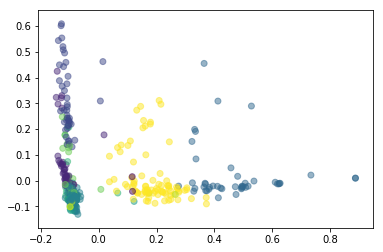

Comparing k-means clusters against the data:
text_source  Beowulf  Blake  Burns  Doolittle  Homer  Keats  Longfellow  \
row_0                                                                     
0                  0      0      5          1      0      0           2   
1                 10      3      3          4      6      5           3   
2                  2     11      3          1      3      6           7   
3                  3      4      6          5      5      6           5   
4                 36     17     31         19     22     24          10   
5                  0      6      3          0      4      0           0   
6                  0      7      0          0      0      0          10   
7                  4      3      2          1      5     15           8   
8                  1      0      0          0      1      0           0   
9                  5      8     12         14      8     12           5   

text_source  Milton  Sappho  Whitman  
row_0          

In [184]:
start_time = time.time()

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(int(X_norm.shape[0]/2)).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha = 0.5)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

print("--- %s seconds for model fit ---" % (time.time() - start_time))

In [185]:
X_norm.shape

(531, 2388)

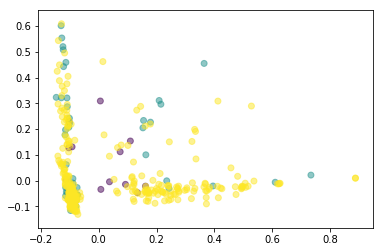

Comparing k-means clusters against the data:
text_source  Beowulf  Blake  Burns  Doolittle  Homer  Keats  Longfellow  \
row_0                                                                     
0                  2      1      0          7      1      1           2   
1                  3      3      3          1      0      6           3   
2                  3      3      0          1      2      6           7   
3                 33     14     32         13     18     25          10   
4                  1      1      2          0      7      1           7   
5                  0      7      1          0      3      0           0   
6                  4     19      3          1      5      9          11   
7                  9      2      6          4      7      5           4   
8                  5      4     16         18      9     14           6   
9                  1      5      2          0      2      1           0   

text_source  Milton  Sappho  Whitman  
row_0          

In [186]:
#plot true values
start_time = time.time()

# Normalize the data.
X_norm = normalize(X)

#pca = PCA(2).fit(X_norm)
# Reduce it to two components.
X_pca = PCA(int(X_norm.shape[0]/2)).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

labels = y.map(lambda x: 0 if x == "Milton" else (1 if x == "Blake" else 2))
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha = 0.5)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

print("--- %s seconds to model ---" % (time.time() - start_time))

In [187]:
start_time = time.time()

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

print("--- %s seconds to model ---" % (time.time() - start_time))

Comparing k-means and mini batch k-means solutions:
col_0   0   1  2    3   4   5   6   7   8   9
row_0                                        
0       0   0  0    5   1   0   0   1   0   1
1       0   6  4    0   1   2   6   7  92   0
2       0   0  0    0   0   0   0   0   1   0
3       1   1  8    5   0   0   0   0   0   0
4       0   0  0    0   0   0  48   2   0   0
5       0   0  4    7   0   1   7   2   2   0
6       0   0  0    5   0   0   0   0   0   0
7      14  16  9  167  22  13   0  31   0  10
8       1   1  2    2   6   0  10   1   0   1
9       0   0  1    3   0   1   0   0   0   0
--- 0.09071993827819824 seconds to model ---


In [188]:
#pca(reduce by half then only plot first 2) or lsa , ica, Gaussian Mixture Model

In [189]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    stratify = y,
                                                    random_state=0)

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

In [190]:
y_test.value_counts()

Keats         17
Burns         16
Sappho        16
Blake         15
Beowulf       15
Homer         14
Longfellow    13
Doolittle     11
Whitman       10
Milton         6
Name: text_source, dtype: int64

In [191]:
# Spot Check Algorithms
models = []
models.append(('NBB', BernoulliNB()))
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('GMM', GaussianMixture()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    split = StratifiedShuffleSplit(n_splits=10, random_state=1337)
    model = model.fit(X_train,y_train)
    cv_results = cross_val_score(model, X_test, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NBB: 0.171429 (0.065465)
RFC: 0.164286 (0.045737)
KNN: 0.142857 (0.031944)
DTC: 0.157143 (0.104978)
GNB: 0.400000 (0.096890)
SVC: 0.142857 (0.000000)
GBC: 0.228571 (0.069985)
ABC: 0.150000 (0.038465)
ETC: 0.264286 (0.101267)
QDA: 0.150000 (0.081127)


In [192]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(rfc, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9748743718592965

Test set score: 0.3383458646616541

Cross Validation:
    0.19 (+/- 0.10)
[0.14285714 0.21428571 0.07142857 0.14285714 0.35714286]


In [193]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
lr.fit(X_train, y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(lr, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9673366834170855

Test set score: 0.5037593984962406

Cross Validation:
    0.34 (+/- 0.10)
[0.21428571 0.42857143 0.5        0.28571429 0.28571429]


In [194]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))


split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(clf, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9723618090452262

Test set score: 0.45112781954887216

Cross Validation:
    0.27 (+/- 0.08)
[0.21428571 0.35714286 0.14285714 0.35714286 0.28571429]


In [195]:
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [196]:
# Load and clean the data.
leaves = gutenberg.paras('whitman-leaves.txt')
leaves_paras=[]
for paragraph in leaves:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    leaves_paras.append(' '.join(para))

paradise = gutenberg.paras('milton-paradise.txt')
paradise_paras=[]
for paragraph in paradise:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    paradise_paras.append(' '.join(para))
    
    
blake = gutenberg.paras('blake-poems.txt')
blake_paras=[]
for paragraph in blake:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    blake_paras.append(' '.join(para))

    
new_corpus = PlaintextCorpusReader("",'.txt')    
    
hiawatha = new_corpus.paras("The Song Of Hiawatha, by Henry W. Longfellow.txt")
hiawatha_paras=[]
for paragraph in hiawatha:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    hiawatha_paras.append(' '.join(para))


endymion = new_corpus.paras("Endymion, by John Keats.txt")
endymion_paras=[]
for paragraph in endymion:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    endymion_paras.append(' '.join(para))


odyssey = new_corpus.paras("The Odyssey by Homer.txt")
odyssey_paras=[]
for paragraph in odyssey:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    odyssey_paras.append(' '.join(para))


burns = new_corpus.paras("The Complete Works of Robert Burns.txt")
burns_paras=[]
for paragraph in burns:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    burns_paras.append(' '.join(para))


sea = new_corpus.paras("Sea Garden by Hilda Doolittle.txt")
sea_paras=[]
for paragraph in sea:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    sea_paras.append(' '.join(para))
    

beowulf = new_corpus.paras("Beowulf by Leslie Hall.txt")
beowulf_paras=[]
for paragraph in beowulf:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    beowulf_paras.append(' '.join(para))


sappho = new_corpus.paras("Sappho- One Hundred Lyrics by Bliss Carman.txt")
sappho_paras=[]
for paragraph in sappho:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    sappho_paras.append(' '.join(para))


In [197]:
# Group into paragraphs.
paradise_paras = [[para, "Milton"] for para in paradise_paras]
blake_paras = [[para, "Blake"] for para in blake_paras]
leaves_paras = [[para, "Whitman"] for para in leaves_paras]
hiawatha_paras = [[para, "Longfellow"] for para in hiawatha_paras]
endymion_paras = [[para, "Keats"] for para in endymion_paras]
odyssey_paras = [[para, "Homer"] for para in odyssey_paras]
burns_paras = [[para, "Burns"] for para in burns_paras]
sea_paras = [[para, "Doolittle"] for para in sea_paras]
beowulf_paras = [[para, "Beowulf"] for para in beowulf_paras]
sappho_paras = [[para, "Sappho"] for para in sappho_paras]

# Combine the sentences from the two novels into one data frame.
paragraphs = pd.DataFrame(paradise_paras + blake_paras + 
                         leaves_paras + hiawatha_paras + 
                         endymion_paras + odyssey_paras +
                         burns_paras + sea_paras +
                         beowulf_paras + sappho_paras)
paragraphs.head()

,0,1
0,[ Paradise Lost by John Milton 1667 ],Milton
1,Book I,Milton
2,"Of Man ' s first disobedience , and the fruit ...",Milton
3,Book II,Milton
4,"High on a throne of royal state , which far Ou...",Milton


In [198]:
print(len(paradise_paras))
print(len(blake_paras))
print(len(leaves_paras))
print(len(hiawatha_paras))
print(len(endymion_paras))
print(len(odyssey_paras))
print(len(burns_paras))
print(len(sea_paras))
print(len(beowulf_paras))
print(len(sappho_paras))
print(len(paragraphs))

29
284
2478
681
140
216
11621
252
1164
461
17326


In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(paragraphs.drop(1,axis=1),paragraphs[1], 
                                                    test_size=0.25, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=3, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [200]:
#Applying the vectorizer
paras_tfidf=vectorizer.fit_transform(paragraphs.drop(1,axis=1)[0].tolist())
print("Number of features: %d" % paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(paras_tfidf, test_size=0.25, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of sentences
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per sentence
tfidf_bysent = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]


Number of features: 9301


In [201]:
paragraphs.drop(1,axis=1)[0]

0                    [ Paradise Lost by John Milton 1667 ]
1                                                   Book I
2        Of Man ' s first disobedience , and the fruit ...
3                                                  Book II
4        High on a throne of royal state , which far Ou...
5                                                 Book III
6        Hail , holy Light , offspring of Heaven firstb...
7        00021053 Thou , therefore , whom thou only can...
8                                                  Book IV
9        O , for that warning voice , which he , who sa...
10       00081429 Which to our general sire gave prospe...
11                                                  Book V
12       Now Morn , her rosy steps in the eastern clime...
13                                                 Book VI
14       All night the dreadless Angel , unpursued , Th...
15                                                Book VII
16       Descend from Heaven , Urania , by that name If.

In [205]:
# Spot Check Algorithms
models = []
models.append(('NBB', BernoulliNB()))
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('GMM', GaussianMixture()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    split = StratifiedShuffleSplit(n_splits=10, random_state=1337)
    model = model.fit(X_train_tfidf_csr,y_train)
    cv_results = cross_val_score(model, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NBB: 0.724885 (0.009622)
RFC: 0.756221 (0.018195)
KNN: 0.688479 (0.002258)
DTC: 0.728571 (0.013427)


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [202]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train_tfidf_csr, y_train)

print('Training set score:', rfc.score(X_train_tfidf_csr, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf_csr, y_test))

split = StratifiedShuffleSplit(n_splits=10, random_state=1337)

score = cross_val_score(rfc, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9676773895644143

Test set score: 0.804247460757156

Cross Validation:
    0.76 (+/- 0.01)
[0.75115207 0.74423963 0.75806452 0.77419355 0.76728111 0.77419355
 0.76267281 0.74884793 0.76036866 0.75806452]


In [203]:
lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
lr.fit(X_train_tfidf_csr, y_train)

print('Training set score:', lr.score(X_train_tfidf_csr, y_train))
print('\nTest set score:', lr.score(X_test_tfidf_csr, y_test))

split = StratifiedShuffleSplit(n_splits=10, random_state=1337)

score = cross_val_score(lr, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.8355394797598892

Test set score: 0.801477377654663

Cross Validation:
    0.71 (+/- 0.01)
[0.71889401 0.70967742 0.70967742 0.70506912 0.71198157 0.7235023
 0.70967742 0.70506912 0.71658986 0.71889401]


In [204]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_tfidf_csr, y_train)

print('Training set score:', clf.score(X_train_tfidf_csr, y_train))
print('\nTest set score:', clf.score(X_test_tfidf_csr, y_test))

split = StratifiedShuffleSplit(n_splits=10, random_state=1337)

score = cross_val_score(lr, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.8360012313375405

Test set score: 0.7698522622345337

Cross Validation:
    0.71 (+/- 0.01)
[0.71889401 0.70967742 0.70967742 0.70506912 0.71198157 0.7235023
 0.70967742 0.70506912 0.71658986 0.71889401]
